In [1]:
import sys
import argparse
import configparser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import cdist
from metadata.const import features, dtypes, class_label

In [2]:
def get_config(section):
    config = configparser.RawConfigParser()
    config.read('../settings.ini')
    return dict(config.items(section))

In [3]:
def get_box_whisker_range(df):
    q1 = df.quantile(q=0.25)
    q3 = df.quantile(q=0.75)
    iqr = q3 - q1
    min_range = q1 - 1.5 * iqr
    max_range = q3 + 1.5 * iqr

    return min_range, max_range

In [4]:
def remove_zero_variance(df):
    const_filter = VarianceThreshold()
    const_filter.fit(df)
    cols = const_filter.get_support(indices=True)
    return df.iloc[:, cols]

In [5]:
def plot_correlation(correlation, filename, save=True, labels=None):
    fig = plt.figure(figsize=(10.41, 7.29))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlation, vmin=-1, vmax=1)
    fig.colorbar(cax)
    if labels:
        ticks = np.arange(0, len(labels), 1)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        plt.setp(ax.get_xticklabels(), rotation=45, ha="left",
                rotation_mode="anchor")
    if save:
        plt.savefig(filename)
    else:
        plt.show()

In [6]:
filename = 'sample-200000.csv'
df = pd.read_csv(f'../dataset/{filename}', dtype=dtypes, low_memory=True)
df.drop(
    [
        features['unnamed0'],
        features['flow_id'],
        features['source_ip'],
        features['source_port'],
        features['destination_ip'],
        features['destination_port'],
        features['timestamp'],
        features['similar_http'],
        features['protocol'],
        features['inbound']
    ],
    axis=1,
    inplace=True
)

In [7]:
df.describe()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.993560e+05,199356.000000,199356.000000,199356.000000,1.993560e+05,199356.000000,199356.000000,199356.000000,199356.000000,199356.000000,...,199356.000000,1.993560e+05,1.993560e+05,1.993560e+05,1.993560e+05,1.993560e+05,199356.0,1.993560e+05,1.993560e+05,1.993560e+05
mean,6.861276e+06,6.118502,5.226198,911.241089,4.031478e+03,292.215973,212.935425,229.106689,26.432558,156.694351,...,3.559617,1.341337e+08,5.384279e+04,2.435223e+04,8.642516e+04,3.904421e+04,2349879.5,2.082385e+05,2.546252e+06,2.169335e+06
std,2.476061e+07,70.325655,109.940438,2962.936035,1.979387e+05,437.729858,354.635590,352.126343,99.267014,553.208618,...,62.640881,6.972669e+08,4.506140e+05,2.249541e+05,6.185284e+05,4.085940e+05,9930718.0,1.919363e+06,1.054426e+07,9.605932e+06
min,0.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2.000000,0.000000,12.000000,0.000000e+00,6.000000,6.000000,6.000000,0.000000,0.000000,...,1.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.200000e+01,2.000000,0.000000,123.000000,0.000000e+00,46.000000,31.000000,43.000000,0.000000,0.000000,...,1.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.469050e+04,2.000000,2.000000,956.000000,1.800000e+01,419.000000,330.000000,359.500000,0.000000,6.000000,...,1.000000,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
max,1.199975e+08,20444.000000,31700.000000,208524.000000,5.842950e+07,3620.000000,2131.000000,2131.000000,1448.583008,3627.000000,...,18766.000000,4.294967e+09,4.050800e+07,1.063756e+07,4.050800e+07,4.050800e+07,117569200.0,6.961402e+07,1.175692e+08,1.175692e+08


In [8]:
for col in df.select_dtypes(exclude='category').columns.tolist():
    df.loc[df[col] < 0, col] = np.nan

In [9]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [10]:
print(df.isna().sum().sort_values(ascending=False))
df = df.drop([features['flow_packets_s'], features['flow_bytes_s']], axis=1)

 Flow Packets/s         5030
Flow Bytes/s            5030
 Flow Duration             0
 Average Packet Size       0
 Fwd Avg Bulk Rate         0
                        ... 
 Bwd IAT Std               0
 Bwd IAT Mean              0
Bwd IAT Total              0
 Fwd IAT Min               0
 Label                     0
Length: 78, dtype: int64


In [11]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
X = df.drop(class_label, axis=1)
y = df[class_label]

In [13]:
columns = set(X.columns)
X = remove_zero_variance(X)
print(columns - set(X.columns))

{' Fwd Avg Bulk Rate', ' Fwd URG Flags', ' Bwd Avg Bytes/Bulk', 'Bwd Avg Bulk Rate', ' PSH Flag Count', ' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' ECE Flag Count', ' Bwd Avg Packets/Bulk', ' Fwd Avg Packets/Bulk', 'FIN Flag Count'}


In [14]:
numeric_X = X.select_dtypes(exclude='category')
corr_matrix = numeric_X.corr(method='pearson')

In [15]:
redundent_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            redundent_features.add(corr_matrix.columns[i])

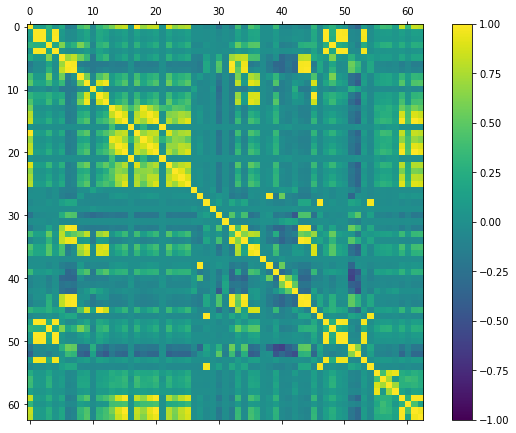

In [16]:
plot_correlation(
    corr_matrix,
    'numeric-correlation.png',
    save=False
#     labels=numeric_X.columns.to_list()
)

In [17]:
print(redundent_features)
X.drop(list(redundent_features), axis=1, inplace=True)

{'Subflow Fwd Packets', ' RST Flag Count', ' Idle Max', ' Max Packet Length', ' Flow IAT Std', ' Fwd IAT Std', ' Total Length of Bwd Packets', ' Packet Length Std', ' Fwd IAT Mean', ' Bwd IAT Std', ' Packet Length Variance', ' Fwd Header Length.1', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Fwd IAT Total', 'Idle Mean', ' min_seg_size_forward', ' Packet Length Mean', ' act_data_pkt_fwd', ' Subflow Bwd Packets', 'Bwd IAT Total', ' Active Min', ' Fwd IAT Min', ' Subflow Fwd Bytes', ' Fwd Packet Length Mean', ' Total Backward Packets', ' Subflow Bwd Bytes', ' Fwd IAT Max', ' Flow IAT Max', ' Avg Fwd Segment Size', ' Avg Bwd Segment Size', ' Min Packet Length', ' Active Max', ' Average Packet Size', ' Idle Min', ' Bwd IAT Max'}


In [18]:
scale = StandardScaler()
X_norm = scale.fit_transform(X)
print(X_norm.shape)

(199356, 27)


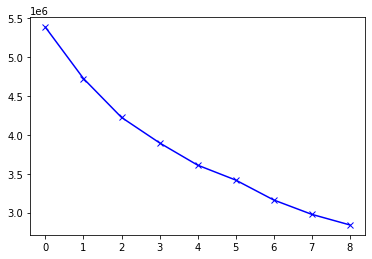

In [19]:
cost = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_norm)
    cost.append(kmeans.inertia_)
plt.plot(cost, 'bx-')

In [20]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(X_norm)
kmeans_labels = kmeans.labels_

In [21]:
pca = PCA(2)
pca.fit(X_norm)
X_PCA = pca.transform(X_norm)
X_PCA.shape

(199356, 2)

In [22]:
x_pca, y_pca = X_PCA[:, 0], X_PCA[:, 1]
colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow',
          4: 'orange',
          5: 'purple',
          6: 'pink',
          7: 'gray',
          8: 'brown'}
pca_df = pd.DataFrame({'x': x_pca, 'y': y_pca, 'label': kmeans_labels})
groups = pca_df.groupby('label')

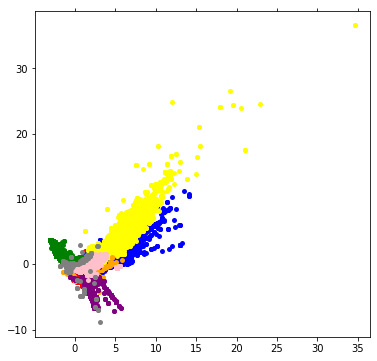

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='black')
plt.show()

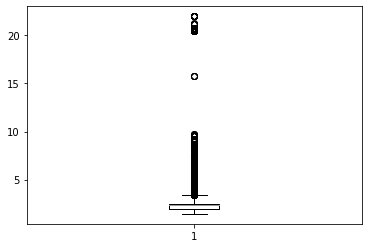

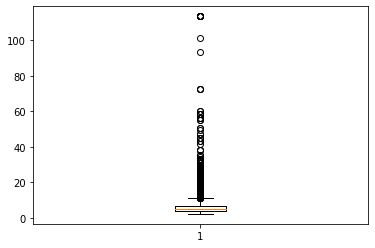

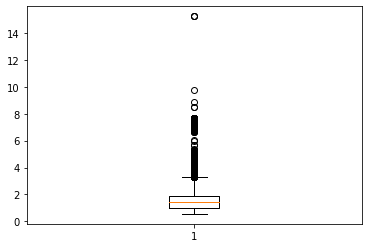

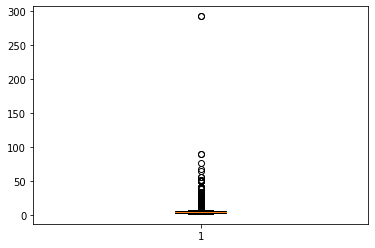

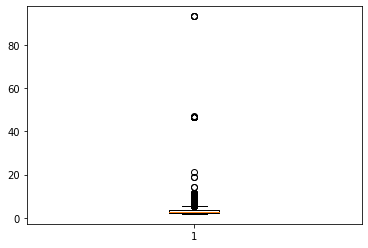

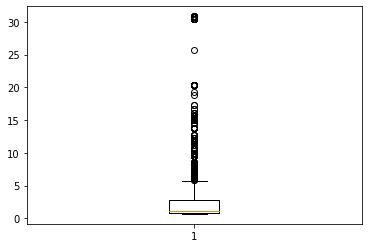

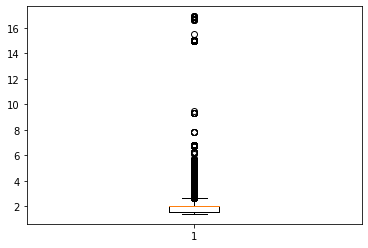

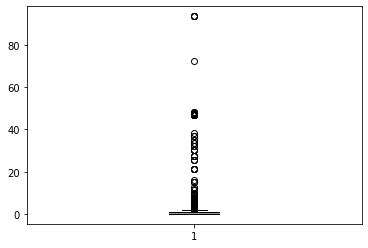

In [24]:
outliers = []
for i, center in enumerate(centroids):
    distances = cdist([center], X_norm[kmeans_labels == i], 'euclidean').ravel()
    truthness = (kmeans_labels == i)
    indices = []
    for j in range(len(truthness)):
        if truthness[j]:
            indices.append(j)
    min_range, max_range = get_box_whisker_range(pd.DataFrame({'distance': pd.Series(distances)}))
    min_range = min_range['distance']
    max_range = max_range['distance']
    for i in range(len(indices)):
        if distances[i] > max_range or distances[i] < min_range:
            outliers.append(indices[i])
    plt.boxplot(distances.tolist())
    plt.show()

In [25]:
print(len(outliers))
X.drop(outliers, axis=0, inplace=True)
y.drop(outliers, axis=0, inplace=True)

26899


In [26]:
df = pd.concat([X, y], axis=1)

In [27]:
df.to_csv(f'../dataset/clean-{filename}', index=False)